# Imports

In [73]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import scipy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU
from tensorflow.keras.callbacks import Callback

### Load data and get file path

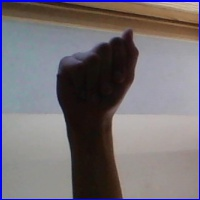

In [74]:
data_path = '../Data/asl_alphabet_train/asl_alphabet_train/'

data_dir = pathlib.Path(data_path)

data_path2 = '../Data/asl_alphabet_test/asl_alphabet_test/'

data_dir2 = pathlib.Path(data_path2)

#A = list(data_dir.glob('A/*'))
#image_count = len(A)
#PIL.Image.open(str(A[0]))

A = list(data_dir.glob('A/*'))
image_count = len(A)
PIL.Image.open(str(A[0]))

### Splitting data into train and validation datasets

In [75]:
batch_size = 16
img_height = 200
img_width = 200

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=16,
    subset="training",
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb"
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(200, 200),
    batch_size=16,
    subset="validation",
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    data_dir2,
    target_size=(200, 200),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=True,
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 29 images belonging to 29 classes.


#### Resnet model

In [76]:
class_names = train_generator.classes
label_map = (train_generator.class_indices)
num_classes = len(label_map)
print(num_classes)

resnet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(200,200,3),
    pooling=None,
    classes=num_classes,)

resnet.trainable = False

model = Sequential()
model.add(resnet)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128,activation="softmax"))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(64,activation="softmax"))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(29,activation="softmax"))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              #run_eagerly=True
                )
              
model.summary()

29
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_8 (Dense)             (None, 29)                2910237   
                                                                 
Total params: 26,497,949
Trainable params: 2,910,237
Non-trainable params: 23,587,712
_________________________________________________________________


#### VGG16

In [77]:
#class_names = train_generator.classes
#label_map = (train_generator.class_indices)
#num_classes = len(label_map)
#print(num_classes)
#
#model = tf.keras.applications.VGG16(
#    include_top=True,
#    weights=None,
#    input_tensor=None,
#    input_shape=(200,200,3),
#    pooling=None,
#    classes=num_classes,)
#
#model.compile(optimizer='sgd',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'],
#              #run_eagerly=True
#                )
#              
#model.summary()

#### Basic model.

In [78]:
#class_names = train_generator.classes
#label_map = (train_generator.class_indices)
#num_classes = len(label_map)
#print(num_classes)
#
#model = Sequential([
#  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes)
#])
#
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'],
#              run_eagerly=True)
#              
#model.summary()

In [80]:
#model = tf.keras.models.load_model('ASL_res50_150.keras')

#### Running the model

In [70]:
epochs = 150

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    batch_size=batch_size,
                    epochs=epochs
)


Epoch 1/150
4350/4350 [==============================] - 196s 44ms/step - loss: 2.4874 - accuracy: 0.3245 - val_loss: 2.9155 - val_accuracy: 0.2694
Epoch 2/150
4350/4350 [==============================] - 189s 44ms/step - loss: 1.6449 - accuracy: 0.5230 - val_loss: 2.5763 - val_accuracy: 0.3041
Epoch 3/150
4350/4350 [==============================] - 191s 44ms/step - loss: 1.3036 - accuracy: 0.6134 - val_loss: 2.5508 - val_accuracy: 0.2997
Epoch 4/150
4350/4350 [==============================] - 190s 44ms/step - loss: 1.0902 - accuracy: 0.6753 - val_loss: 2.7804 - val_accuracy: 0.2737
Epoch 5/150
4350/4350 [==============================] - 190s 44ms/step - loss: 0.9422 - accuracy: 0.7175 - val_loss: 2.2401 - val_accuracy: 0.3582
Epoch 6/150
4350/4350 [==============================] - 199s 46ms/step - loss: 0.8270 - accuracy: 0.7505 - val_loss: 1.9674 - val_accuracy: 0.4109
Epoch 7/150
4350/4350 [==============================] - 201s 46ms/step - loss: 0.7261 - accuracy: 0.7803 - val_

Epoch 56/150
4350/4350 [==============================] - 567s 130ms/step - loss: 0.1092 - accuracy: 0.9696 - val_loss: 2.2311 - val_accuracy: 0.5394
Epoch 57/150
4350/4350 [==============================] - 600s 138ms/step - loss: 0.1030 - accuracy: 0.9709 - val_loss: 2.3745 - val_accuracy: 0.5498
Epoch 58/150
4350/4350 [==============================] - 628s 144ms/step - loss: 0.1056 - accuracy: 0.9704 - val_loss: 2.3185 - val_accuracy: 0.5601
Epoch 59/150
4350/4350 [==============================] - 625s 144ms/step - loss: 0.1097 - accuracy: 0.9687 - val_loss: 2.1680 - val_accuracy: 0.5528
Epoch 60/150
4350/4350 [==============================] - 613s 141ms/step - loss: 0.0945 - accuracy: 0.9738 - val_loss: 3.9920 - val_accuracy: 0.4534
Epoch 61/150
4350/4350 [==============================] - 577s 133ms/step - loss: 0.0993 - accuracy: 0.9717 - val_loss: 2.5850 - val_accuracy: 0.5221
Epoch 62/150
4350/4350 [==============================] - 580s 133ms/step - loss: 0.0910 - accuracy:

In [ ]:
model.save('ASL_res_150_2.keras')

#### Checking for accuracy with test.

In [72]:
validation_generator.reset()

score = model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predict=model.predict(test_generator)
y_classes = predict.argmax(axis=-1)
pred = np.argmax(y_classes)
print(y_classes)

1088/1088 [==============================] - 38s 35ms/step - loss: 2.4242 - accuracy: 0.5994
Test loss: 2.424236297607422
Test accuracy: 0.5993677973747253
29/29 [==============================] - 2s 25ms/step
[ 6  8 13 23 20 25 26  9 28 19  3 24 14 12 21  5 27 15  4 17 16  1 18 10
  0  7 11  2 22]


In [39]:
print(history.history['accuracy'])
#score = model.evaluate(test_generator, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])
#model.save('ASL_res50_150.keras')

KeyError: 'val_acc'

#### Creating Model history and printing out statistics in form of graphs.

ValueError: x and y must have same first dimension, but have shapes (5,) and (150,)

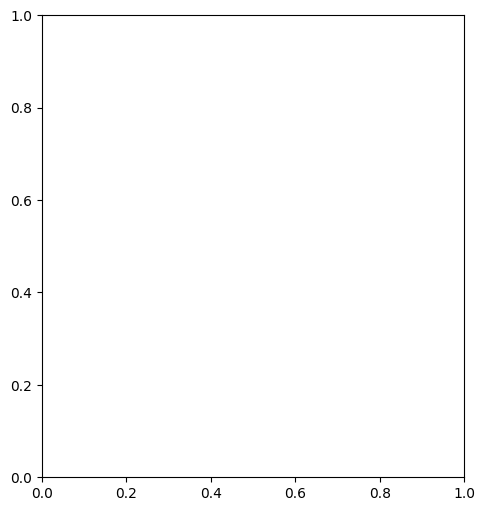

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

